In [1]:
pip install pytorch_pretrained_bert 

     |████████████████████████████████| 133kB 2.8MB/s 


In [2]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel
import numpy as np
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib
import matplotlib.pyplot as plt
import nltk
from nltk import tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

##Funcoes

In [0]:
def content_sentences(body):
        sentences = tokenize.sent_tokenize(body)
        return [c for c in sentences if len(c) > 75 and not c.lower().startswith('but') and
                not c.lower().startswith('and')
                and not c.lower().__contains__('quiz') and
                not c.lower().startswith('or')]

def tokenize_input(text):
        tokenized_text = tokenizer.tokenize(text)
        indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
        return torch.tensor([indexed_tokens])

def extract_embeddings(text):
        tokens_tensor = tokenize_input(text)
        hidden_states, pooled = model(tokens_tensor)
        pooled = hidden_states[-2].mean(dim=1)
        return pooled

##Classes

In [0]:
class ClusterFeatures(object):
    def __init__(self, features, algorithm='kmeans', pca_k=2):
        if pca_k:
            self.features = PCA(n_components=pca_k).fit_transform(features)
        else:
            self.features = features
        self.algorithm = algorithm
        self.pca_k = pca_k

    def __get_model(self, k):
        if self.algorithm == 'gmm':
            return GaussianMixture(n_components=k)
        if self.algorithm == 'affinity':
            return AffinityPropagation()
        return KMeans(n_clusters=k)

    def __get_centroids(self, model):
        if self.algorithm == 'gmm':
            return model.means_
        return model.cluster_centers_

    def __find_closest_args(self, centroids):
        centroid_min = 1e7
        cur_arg = -1
        args = {}
        used_idx = []
        for j, centroid in enumerate(centroids):
            for i, feature in enumerate(self.features):
                value = np.sum(np.abs(feature - centroid))
                if value < centroid_min and i not in used_idx:
                    cur_arg = i
                    centroid_min= value
            used_idx.append(cur_arg)
            args[j] = cur_arg
            centroid_min = 1e7
            cur_arg = -1
        return args

    def cluster(self, ratio=0.1):
        k = 1 if ratio * len(self.features) < 1 else int(len(self.features) * ratio)
        model = self.__get_model(k).fit(self.features)
        centroids = self.__get_centroids(model)
        cluster_args = self.__find_closest_args(centroids)
        sorted_values = sorted(cluster_args.values())
        return sorted_values

    def create_plots(self, k=4, plot_location='./cool_model.png', title = ''):
        if self.pca_k != 2:
            raise RuntimeError("Must be dimension of 2")

        model = self.__get_model(k)
        model.fit(self.features)
        y = model.predict(self.features)
        plt.title(title)
        plt.scatter(self.features[:, 0], self.features[:, 1], c=y, s=50, cmap='viridis')
        centers = model.cluster_centers_
        plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
        plt.savefig(plot_location)

##Aplicacao

In [0]:
body = '''
Haiti is no stranger to crisis. Amid civil unrest, staggering unemployment, lack of quality health care and severe poverty, the country now faces a global pandemic that officials say could worsen its hunger crisis.
"The situation has been described as a perfect storm approaching," Dr. Carissa F. Etienne, Director of the Pan American Health Organization (PAHO) said in a briefing Tuesday, warning the spread of the coronavirus could result in famine.
Haiti's World Food Programme Director Pierre Honnorat told CNN that he expects hunger to "get much worse."
"Close to four million Haitians were already facing hunger before the Covid-19 crisis. With the continued depreciation of the gourde [Haitian currency], the steady rise in food prices, and new restrictions on movements and disruptions of economic activities, the most vulnerable Haitians will be pushed deeper into poverty," Honnorat said.
The World Food Programme 2020 report on global food crises attributed Haiti's food insecurity in part to political instability last year, which "led to a slowdown or halt of public services and suspension of bilateral investment and support." The report also cites factors such as high inflation, unemployment and poor economic conditions.
The country's reliance on imported foods also leaves it particularly vulnerable to the pandemic's global economic toll, according to one economic expert. "With remittances, exports, and tourism all expected to crash, Haiti will be less and less able to import the basic goods the country has come to rely upon. Inflation, which is already higher than it has been in years, is likely to increase further -- putting basic goods out of reach of more and more families," said Jake Johnston, senior research associate at the Washington-based Center for Economic and Policy Research.
Miguel Wilner, a 40-year-old Haitian who lost his home after the 2010 earthquake devastated the nation, lives in the Caradeux settlement camp in the north of Port-au-Prince. With little access to electricity, let alone media resources, Wilner and many other Haitians remain in the dark about information surrounding Covid-19.
Coronavirus quickly spread around the world starting late last year, new genetic analysis shows
Coronavirus quickly spread around the world starting late last year, new genetic analysis shows
Wilner fears the outbreak could prove dire to his and other settlement camps.
"We are defenseless against this new virus," Wilner tells CNN. "People are already dying of hunger, here at the camp we have no help and we don't know what will happen. At this point anything is possible, we have very little information on what's going on. On top of the hunger and lack of sanitation, we have no electricity to stay connected with the news."
According to the International Organization for Migration, more than 34,000 people live in 22 settlement camps across Haiti. "Access remains difficult in these areas, no humanitarian assistance is being provided at the moment," the IOM said.
Haiti has so far reported 100 confirmed cases of the novel coronavirus and 11 deaths, according to PAHO Director Etienne, who says that the probability of further spread is "extremely high."
Etienne adds that it is "extremely difficult to institute proper social distancing in Haiti," citing lack of awareness of the threat among communities and many people living in crowded households "where quarantine and isolation are challenging."
She also indicated the effect of the Covid-19 outbreak on Haiti's healthcare system could be grim.
"The health system in Haiti has limited capacity. There are few beds for treating Covid-19, insufficient numbers of healthcare professionals and insufficient personal protective equipment. The security of the Covid-19 designated hospitals and the safety of community health workers is also of grave concern. There is real danger of a large-scale outbreak followed by a humanitarian crisis in Haiti," Etienne said.
Coronavirus pandemic could contribute to surge of other deadly diseases, experts warn
Coronavirus pandemic could contribute to surge of other deadly diseases, experts warn
In March, Haitian President Jovenel Moïse announced a nationwide lockdown after the country confirmed its first two cases. But while lockdown measures remain in place, the government has already reopened textile factories.
In an address to the nation on April 27, Moïse, who has faced calls to resign for more than a year, told Haitians that more difficult days lie ahead.
"As a leader, we should be able to plan for after coronavirus. I have to ask myself, what is waiting for Haiti after the pandemic?" He added, "It is clear [Haiti] will have a lot of challenges, including famine."
But Johnston, the economic researcher, says the pandemic could also give Moïse's government a chance to step up.
"With global supply chains disrupted and access to imports reduced, the Haitian government and international donors may be pushed into supporting national agricultural production in an unprecedented fashion," he said.
"Ironically, this is exactly what peasant organizations, rural families and aid watch dogs have been requesting for years," Johnston said.
'''

In [0]:
initial_sentences = content_sentences(body)

In [7]:
model = BertModel.from_pretrained('bert-large-uncased')

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

100%|██████████| 231508/231508 [00:00<00:00, 4625003.84B/s]


In [9]:
vector_size = 1024

train_vec = np.zeros((len(initial_sentences), vector_size))

for i, t in tqdm(enumerate(initial_sentences)):
            train_vec[i] = extract_embeddings(t).data.numpy()

29it [00:14,  2.03it/s]

[[-0.0441863  -0.47238377  0.16045284 ... -0.18319422  0.09524354
   0.12049031]
 [-0.16902286 -0.31889457  0.0254964  ... -0.03291997 -0.18283747
  -0.28104714]
 [-0.30484843 -0.17915225 -0.57399404 ... -0.48723772  0.71198517
   0.4812474 ]
 ...
 [-0.57725298  0.00371527 -0.42258364 ... -0.09722411  0.81573248
  -0.07012943]
 [ 0.39606699 -0.20890121 -0.40191326 ... -0.1759664   0.02486886
   0.49580246]
 [-0.34662372 -0.29733086 -0.65093511 ...  0.12373579  0.39185339
   0.34293154]]


In [0]:
ratio = 0.2

hidden_args = ClusterFeatures(train_vec).cluster(ratio)

if hidden_args[0] != 0:
            hidden_args.insert(0,0)

resultado = [initial_sentences[j] for j in hidden_args]

# resultado = ' '.join(resultado).strip()

resultado

['Amid civil unrest, staggering unemployment, lack of quality health care and severe poverty, the country now faces a global pandemic that officials say could worsen its hunger crisis.',
 'Miguel Wilner, a 40-year-old Haitian who lost his home after the 2010 earthquake devastated the nation, lives in the Caradeux settlement camp in the north of Port-au-Prince.',
 '"People are already dying of hunger, here at the camp we have no help and we don\'t know what will happen.',
 'Haiti has so far reported 100 confirmed cases of the novel coronavirus and 11 deaths, according to PAHO Director Etienne, who says that the probability of further spread is "extremely high."',
 'Etienne adds that it is "extremely difficult to institute proper social distancing in Haiti," citing lack of awareness of the threat among communities and many people living in crowded households "where quarantine and isolation are challenging."',
 '"With global supply chains disrupted and access to imports reduced, the Haiti

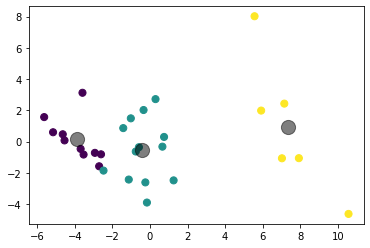

In [0]:
ClusterFeatures(train_vec).create_plots(3)